<a href="https://colab.research.google.com/github/aljebraschool/face_detection_model/blob/main/FaceDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip /content/face_detection_model.zip -d /content


Streaming output truncated to the last 5000 lines.
  inflating: /content/aug_data/train/labels/e3c22ae8-3814-11ee-8084-b4b676d3e2da.114.json  
  inflating: /content/aug_data/train/labels/0cd545fe-3816-11ee-8084-b4b676d3e2da.96.json  
  inflating: /content/aug_data/train/labels/e0909792-3814-11ee-8084-b4b676d3e2da.69.json  
  inflating: /content/aug_data/train/labels/e740323c-3814-11ee-8084-b4b676d3e2da.27.json  
  inflating: /content/aug_data/train/labels/e2d083e6-3814-11ee-8084-b4b676d3e2da.79.json  
  inflating: /content/aug_data/train/labels/d96b3732-3815-11ee-8084-b4b676d3e2da.12.json  
  inflating: /content/aug_data/train/labels/0c2f1b20-3816-11ee-8084-b4b676d3e2da.75.json  
  inflating: /content/aug_data/train/labels/e03e7034-3814-11ee-8084-b4b676d3e2da.51.json  
  inflating: /content/aug_data/train/labels/d9179906-3815-11ee-8084-b4b676d3e2da.104.json  
  inflating: /content/aug_data/train/labels/0c81b9c0-3816-11ee-8084-b4b676d3e2da.47.json  
  inflating: /content/aug_data/train/

# 1. Setup and Get Data

### 1.1 Install Dependencies and Setup

In [ ]:
!pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations

### 1.2 Collect Images Using OpenCV

In [ ]:
import os
import time
import uuid
import cv2

In [ ]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [ ]:
cap = cv2.VideoCapture(1)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

### 1.3 Annotate Images with LabelMe

In [ ]:
!labelme

# 2. Review Dataset and Build Image Loading Function

### 2.1 Import TF and Deps

In [ ]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Limit GPU Memory Growth

In [ ]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
tf.config.list_physical_devices('GPU')

[]

### 2.3 Load Image into TF Data Pipeline

In [ ]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

In [ ]:
images.as_numpy_iterator().next()

In [ ]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [ ]:
images = images.map(load_image)

In [ ]:
images.as_numpy_iterator().next()

In [ ]:
type(images)

### 2.4 View Raw Images with Matplotlib

In [ ]:
image_generator = images.batch(4).as_numpy_iterator()

In [ ]:
plot_images = image_generator.next()

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

# 3. Partition Unaugmented Data

### 3.1 MANUALLY SPLT DATA INTO TRAIN TEST AND VAL

In [ ]:
90*.7 # 63 to train

In [ ]:
90*.15 # 14 and 13 to test and val

### 3.2 Move the Matching Labels

In [ ]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):

        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)

# 4. Apply Image Augmentation on Images and Labels using Albumentations

### 4.1 Setup Albumentations Transform Pipeline

In [ ]:
import albumentations as alb

In [ ]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450),
                         alb.HorizontalFlip(p=0.5),
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2),
                         alb.RGBShift(p=0.2),
                         alb.VerticalFlip(p=0.5)],
                       bbox_params=alb.BboxParams(format='albumentations',
                                                  label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [ ]:
img = cv2.imread(os.path.join('data','train', 'images','0b2eeb4c-3816-11ee-8084-b4b676d3e2da.jpg'))

In [ ]:
with open(os.path.join('data', 'train', 'labels', '0b2eeb4c-3816-11ee-8084-b4b676d3e2da.json'), 'r') as f:
    label = json.load(f)

In [ ]:
label['shapes'][0]['points']

[[245.1655629139073, 249.93377483443706],
 [426.6225165562914, 451.9205298013245]]

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [ ]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [ ]:
coords

In [ ]:
coords = list(np.divide(coords, [640,480,640,480]))

In [ ]:
coords

### 4.4 Apply Augmentations and View Results

In [ ]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [ ]:
augmented['bboxes'][0][2:]

In [ ]:
augmented['bboxes']

In [ ]:
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)),
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [ ]:
for partition in ['train','test','val']:
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try:
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0:
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0
                    else:
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else:
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

### 5.2 Load Augmented Images to Tensorflow Dataset

In [ ]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [ ]:
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [ ]:
val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [ ]:
train_images.as_numpy_iterator().next()

array([[[0.6661152 , 0.82150733, 0.81464463],
        [0.6683211 , 0.82371324, 0.8168505 ],
        [0.66292894, 0.8246936 , 0.81832105],
        ...,
        [0.6297181 , 0.72383577, 0.73694855],
        [0.63284314, 0.73088235, 0.75539213],
        [0.6269608 , 0.7382353 , 0.7769608 ]],

       [[0.6642157 , 0.8015931 , 0.78707105],
        [0.6648284 , 0.80202204, 0.7886642 ],
        [0.6662378 , 0.80741423, 0.80741423],
        ...,
        [0.6298407 , 0.7259191 , 0.7259804 ],
        [0.61268383, 0.72248775, 0.7324142 ],
        [0.61403185, 0.72922796, 0.74197304]],

       [[0.65471816, 0.7996324 , 0.80441177],
        [0.66568625, 0.8       , 0.80245095],
        [0.6523897 , 0.79356617, 0.78572303],
        ...,
        [0.60784316, 0.7242034 , 0.73333335],
        [0.6117647 , 0.73155636, 0.7441176 ],
        [0.6204657 , 0.7253064 , 0.7406863 ]],

       ...,

       [[0.9352941 , 1.        , 0.997549  ],
        [0.96617645, 1.        , 0.99558824],
        [0.9760417 , 1

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [ ]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)

    return [label['class']], label['bbox']

### 6.2 Load Labels to Tensorflow Dataset

In [ ]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [ ]:
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [ ]:
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [ ]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.4275 , 0.01129, 0.8306 , 0.4602 ], dtype=float16))

# 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [ ]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(5040, 5040, 1080, 1080, 1080, 1080)

### 7.2 Create Final Datasets (Images/Labels)

In [ ]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [ ]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [ ]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [ ]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.5176, 0.458 , 0.7236, 0.707 ],
        [0.1442, 0.7173, 0.4797, 1.    ],
        [0.507 , 0.3298, 0.995 , 0.898 ],
        [0.293 , 0.443 , 0.6904, 0.867 ],
        [0.1765, 0.1857, 0.6577, 0.7183],
        [0.3828, 0.    , 0.7153, 0.2607],
        [0.1536, 0.2063, 0.72  , 0.761 ],
        [0.2002, 0.3057, 0.412 , 0.525 ]], dtype=float16))

### 7.3 View Images and Annotations

In [ ]:
data_samples = train.as_numpy_iterator()

In [ ]:
res = data_samples.next()

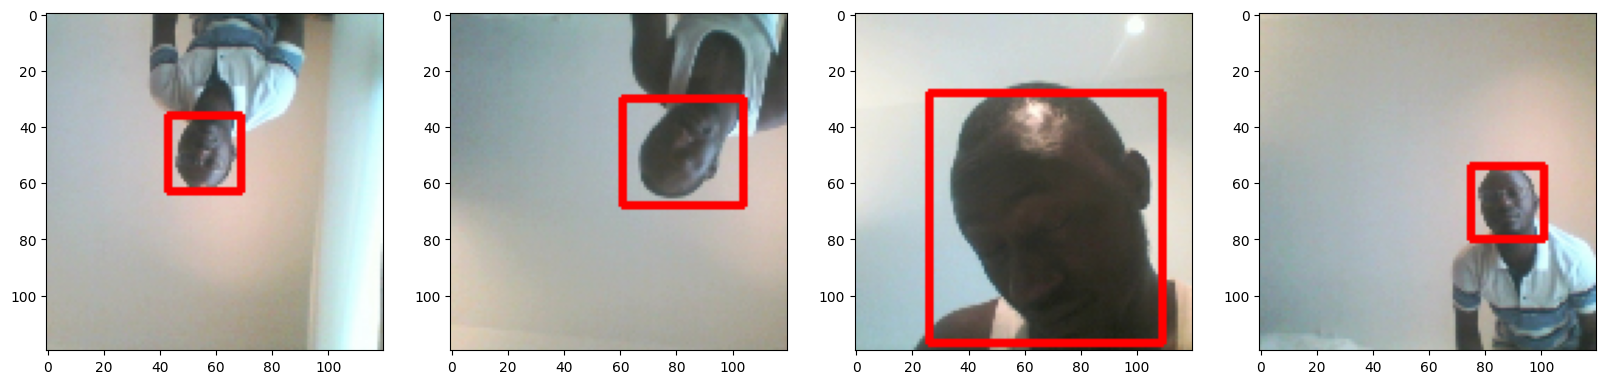

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]

    cv2.rectangle(sample_image,
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [ ]:
vgg = VGG16(include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 8.3 Build instance of Network

In [ ]:
def build_model():
    input_layer = Input(shape=(120,120,3))

    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)

    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)

    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 8.4 Test out Neural Network

In [ ]:
facetracker = build_model()

In [ ]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [ ]:
X, y = train.as_numpy_iterator().next()

In [ ]:
X.shape

(8, 120, 120, 3)

In [ ]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 1s 1s/step


In [ ]:
classes, coords

(array([[0.44495702],
        [0.4179268 ],
        [0.46414667],
        [0.30076098],
        [0.27365083],
        [0.3193608 ],
        [0.44591963],
        [0.2513394 ]], dtype=float32),
 array([[0.59768367, 0.42141455, 0.35170564, 0.4228708 ],
        [0.61692685, 0.39658904, 0.40648246, 0.48147044],
        [0.73271304, 0.44296515, 0.44437647, 0.46064988],
        [0.69745624, 0.53060174, 0.33388594, 0.47681478],
        [0.7202251 , 0.4479373 , 0.36325905, 0.47051862],
        [0.6478023 , 0.47331986, 0.45162886, 0.48911983],
        [0.6512499 , 0.41791806, 0.4258962 , 0.4599245 ],
        [0.7303481 , 0.4930862 , 0.34480318, 0.4930135 ]], dtype=float32))

# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [ ]:
# batches_per_epoch = len(train)
# lr_decay = (1./0.75 -1)/batches_per_epoch

In [ ]:
import tensorflow as tf

# Calculate lr_decay based on batches_per_epoch
batches_per_epoch = len(train)  # You need to replace 'train' with your actual training data
lr_decay = (1.0 / 0.75 - 1.0) / batches_per_epoch

# Define initial_learning_rate and create a learning rate schedule
#initial_learning_rate = 0.0001
initial_learning_rate = 0.003
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=batches_per_epoch,
    decay_rate=lr_decay
)

# Create the optimizer using the learning rate schedule
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


NameError: ignored

### 9.2 Create Localization Loss and Classification Loss

In [ ]:
def localization_loss(y_true, yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))

    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]

    h_pred = yhat[:,3] - yhat[:,1]
    w_pred = yhat[:,2] - yhat[:,0]

    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))

    return delta_coord + delta_size

In [ ]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test out Loss Metrics

In [ ]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=5.49498>

In [ ]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=1.0346403>

In [ ]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=5.49498>

# 10. Train Neural Network

### 10.1 Create Custom Model Class

In [ ]:
class FaceTracker(Model):
    def __init__(self, eyetracker,  **kwargs):
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt

    def train_step(self, batch, **kwargs):

        X, y = batch

        with tf.GradientTape() as tape:
            classes, coords = self.model(X, training=True)

            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)

            total_loss = batch_localizationloss+0.5*batch_classloss

            grad = tape.gradient(total_loss, self.model.trainable_variables)

        opt.apply_gradients(zip(grad, self.model.trainable_variables))

        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}

    def test_step(self, batch, **kwargs):
        X, y = batch

        classes, coords = self.model(X, training=False)

        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss

        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}

    def call(self, X, **kwargs):
        return self.model(X, **kwargs)

In [ ]:
model = FaceTracker(facetracker)

In [ ]:
model.compile(opt, classloss, regressloss)

### 10.2 Train

In [ ]:
logdir='logs'

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
630/630 [==============================] - 2127s 3s/step - total_loss: 0.0274 - class_loss: 2.3157e-05 - regress_loss: 0.0274 - val_total_loss: 0.1121 - val_class_loss: 7.2271e-07 - val_regress_loss: 0.1121
Epoch 2/10
630/630 [==============================] - 2102s 3s/step - total_loss: 0.0263 - class_loss: 2.2133e-05 - regress_loss: 0.0263 - val_total_loss: 0.0748 - val_class_loss: 1.5646e-07 - val_regress_loss: 0.0748
Epoch 3/10
630/630 [==============================] - 2126s 3s/step - total_loss: 0.0264 - class_loss: 2.2242e-05 - regress_loss: 0.0264 - val_total_loss: 0.1269 - val_class_loss: 1.4529e-06 - val_regress_loss: 0.1269
Epoch 4/10
630/630 [==============================] - 2094s 3s/step - total_loss: 0.0263 - class_loss: 2.2122e-05 - regress_loss: 0.0263 - val_total_loss: 0.0849 - val_class_loss: 1.0356e-06 - val_regress_loss: 0.0849
Epoch 5/10
630/630 [==============================] - 2122s 3s/step - total_loss: 0.0264 - class_loss: 2.2141e-05 - regress_loss

### 10.3 Plot Performance

In [ ]:
hist.history

{'total_loss': [0.02068026177585125,
  0.012741206213831902,
  0.06084487587213516,
  0.015494748950004578,
  0.027308855205774307,
  0.02980639971792698,
  0.05032667890191078,
  0.02088012546300888,
  0.017348691821098328,
  0.020032722502946854],
 'class_loss': [1.9722268916666508e-05,
  1.5899931895546615e-05,
  8.509893086738884e-05,
  9.469862561672926e-06,
  2.1354791897465475e-05,
  2.2956633983994834e-05,
  4.417654417920858e-05,
  3.561396624718327e-06,
  2.2398027795134112e-05,
  7.338940122281201e-06],
 'regress_loss': [0.02067040093243122,
  0.012733256444334984,
  0.06080232560634613,
  0.015490014106035233,
  0.027298178523778915,
  0.029794922098517418,
  0.0503045916557312,
  0.020878344774246216,
  0.01733749359846115,
  0.02002905309200287],
 'val_total_loss': [0.11207552254199982,
  0.07483819872140884,
  0.1269206404685974,
  0.08485732972621918,
  0.08775244653224945,
  0.1595008373260498,
  0.05142929032444954,
  0.08481547236442566,
  0.1174158826470375,
  0.123

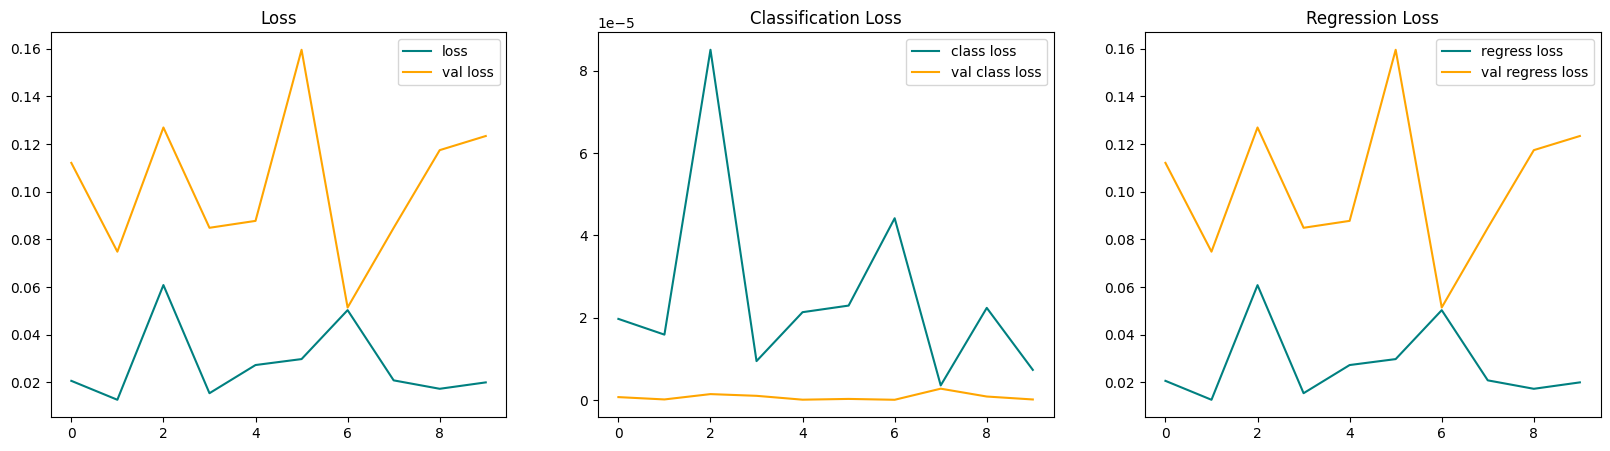

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
test_sample = test_data.next()

In [ ]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 1s 846ms/step


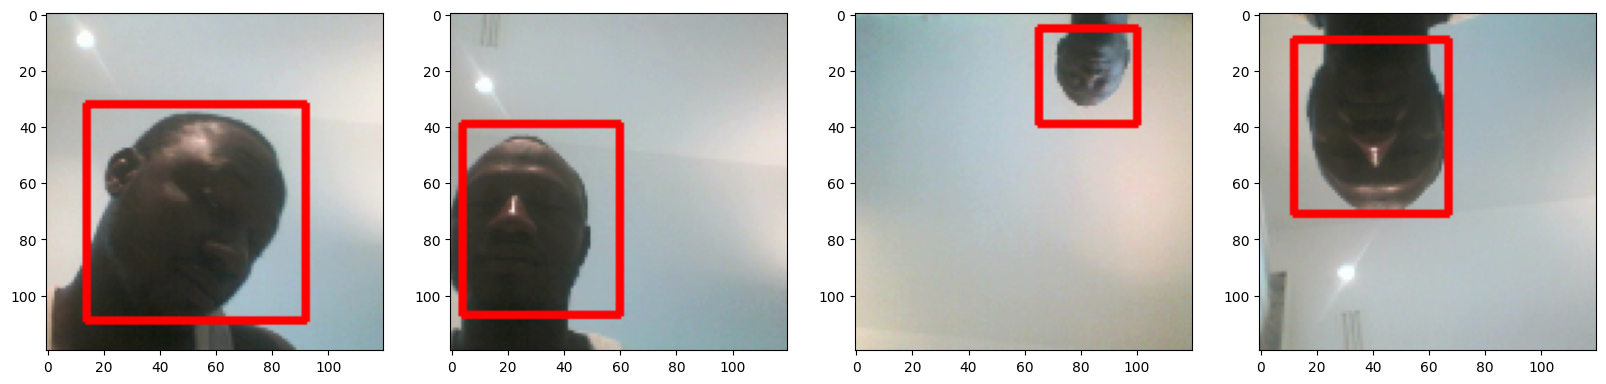

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]

    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image,
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                            (255,0,0), 2)

    ax[idx].imshow(sample_image)

### 11.2 Save the Model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
facetracker.save('facetracker.h5')

In [ ]:
facetracker = load_model('facetracker.h5')

### 11.3 Real Time Detection

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))

    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]

    if yhat[0] > 0.5:
        # Controls the main rectangle
        cv2.rectangle(frame,
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)),
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame,
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])),
                            (255,0,0), -1)

        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

    cv2.imshow('EyeTrack', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()